In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
from tqdm import tqdm
#from efficientnet_pytorch import EfficientNet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=8b6018190eccb1db75325df21f705f5b2b69bcc9f585f718245c2ba2c7f8d5fd
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_everything(42)

setting everything to seed 42


In [5]:
device = torch.device('cuda:0')

In [6]:
data_dir = '/content/drive/My Drive/AudioMnist/free-spoken-digit-dataset-master/recordings'

In [7]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    #X = np.stack([X, X, X])

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32)

In [20]:
def noise_time(image, p = 0.05):
    m1 = image.shape[1]
    m0 = image.shape[0]
    n = int(m1 * p)
    idx = np.random.randint(0, m1 - n)
    noise = np.random.randn(m0, n) * 0.01
    image[:, idx:idx + n] += noise
    return image

def noise_freq(image, p = 0.05):
    m1 = image.shape[1]
    m0 = image.shape[0]
    n = int(m0 * p)
    idx = np.random.randint(0, m0 - n)
    noise = np.random.randn(n, m1) * 0.01
    image[idx:idx + n, :] += noise
    return image

def augmentation(image):
    t = np.random.rand()
    if t < 0.33:
        return noise_time(image)
    elif t < 0.66:
        return noise_freq(image)
    else:
        return image


In [9]:
recordings_old = sorted(os.listdir(data_dir))

In [10]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128

In [11]:
recordings = []
i = 0
for x in recordings_old:
    if i % 100 == 0:
        print(i)
    i += 1
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [12]:
len(recordings)

2903

In [13]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)

In [14]:
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = mono_to_color(melspec)
#melspec = normalize(melspec, mean=None, std=None)
#melspec = self.img_transform(image=melspec)['image']

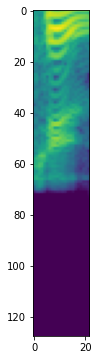

In [15]:
plt.figure(figsize = (20, 6))
plt.imshow(melspec)

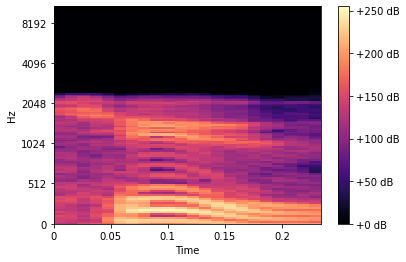

In [ ]:
librosa.display.specshow(melspec, sr=sr, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [16]:
image_size = melspec.shape
image_size

(128, 22)

In [ ]:
#num_samples = []
#for x in recordings:
#    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
#    num_samples.append(y.shape[0])

In [ ]:
#min_num_samples = np.min(num_samples)
#min_num_samples

6888

In [29]:
def get_spectrogram(filename, augment = False):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = mono_to_color(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    #melspec = self.img_transform(image=melspec)['image']
    if augment:
        melspec = augmentation(melspec)

    return torch.tensor(melspec.reshape(1, 128, 22), dtype=torch.float32)

In [32]:
class AudioMNIST(Dataset):
    def __init__(self, mode = 'train', data_dir='./', train_size=0.75, random_seed=42, recordings=[]):
        super().__init__()
        keys = np.arange(len(recordings))
        train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
        augment = False
        if mode == 'train':
            keys = train_keys
            augment = True
        else:
            keys = test_keys
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(get_spectrogram(data_dir + '/' + recordings[i], augment))
            self.labels.append(int(recordings[i][0]))
        

    def __getitem__(self, i):     
        return self.data[i], self.labels[i]

    def __len__(self):
        return self.n


In [33]:
train_dataset = AudioMNIST(mode='train', data_dir=data_dir, recordings=recordings)
test_dataset = AudioMNIST(mode='test', data_dir=data_dir, recordings=recordings)

In [34]:
len(train_dataset)

2177

In [35]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
model = EfficientNet.from_name('efficientnet-b0', in_channels=1, num_classes=10, image_size=image_size).to(device)

In [37]:
max_epoch = 30
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [38]:
for epoch in range(max_epoch):
    print('epoch:', epoch)
    model.train()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    #sum_accuracy = 0
    cnt_objects = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        scores = model(X)
        loss = criterion(scores, y.to(device))
        loss.backward()
        optimizer.step()
        sum_loss += float(loss) * len(y)
        cnt_objects += len(y)

        #all_ys.append(y)
        #all_preds.append(preds)
    mean_loss = sum_loss / cnt_objects
    print('Train')
    print(mean_loss)
    
    #model.eval()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            sum_loss += float(loss) * len(y)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = (y == preds).float().sum()
            sum_accuracy += accuracy
            cnt_objects += len(y)

            #all_ys.append(y)
            #all_preds.append(preds)

    print('TEST')
    mean_loss = sum_loss / cnt_objects
    mean_accuracy = sum_accuracy / cnt_objects
    print('loss:', mean_loss)
    print('accuracy:', mean_accuracy)
    print('*************')

epoch: 0
Train
1.8708316452962082
TEST
loss: 1.2355487977177644
accuracy: tensor(0.5537)
*************
epoch: 1
Train
0.979564918637221
TEST
loss: 0.9937992598399643
accuracy: tensor(0.6708)
*************
epoch: 2
Train
0.6193865767081616
TEST
loss: 0.7147386652050596
accuracy: tensor(0.7824)
*************
epoch: 3
Train
0.42878965210027525
TEST
loss: 0.676845744457455
accuracy: tensor(0.7879)
*************
epoch: 4
Train
0.3200772140460875
TEST
loss: 0.5355167140973829
accuracy: tensor(0.8485)
*************
epoch: 5
Train
0.28194292066948207
TEST
loss: 0.6770171005863789
accuracy: tensor(0.8182)
*************
epoch: 6
Train
0.23417673715495932
TEST
loss: 0.48313275053481425
accuracy: tensor(0.8705)
*************
epoch: 7
Train
0.2025831257689147
TEST
loss: 0.4205607018194908
accuracy: tensor(0.8871)
*************
epoch: 8
Train
0.1243599943053465
TEST
loss: 0.41486150206941547
accuracy: tensor(0.8871)
*************
epoch: 9
Train
0.1455857868746546
TEST
loss: 0.5294010718006733
accura